In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline

## Introduction
In this notebook I use the area weighting method to convert data aggregated by census block (in this case, census return rates) to a the larger neighborhood polygons defined the Hack OR Disaster Team. Metrics such as ratios cannot use the block centroid method since they cannot be allocated by population. The block centroid method is best used on metrics such as counts or sums which make more sense to allocate by population.

As discussed earlier in the season, we explore census return rates here because they have been found in some [literature](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1019.2188&rep=rep1&type=pdf) to have a strong relationship with indicators of social capital. 

In [2]:
# start of by getting the block groups
or_bg = gpd.read_file("Data/cb_2016_41_bg_500k/cb_2016_41_bg_500k.shp")

In [3]:
or_bg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 11 columns):
STATEFP     2628 non-null object
COUNTYFP    2628 non-null object
TRACTCE     2628 non-null object
BLKGRPCE    2628 non-null object
AFFGEOID    2628 non-null object
GEOID       2628 non-null object
NAME        2628 non-null object
LSAD        2628 non-null object
ALAND       2628 non-null int64
AWATER      2628 non-null int64
geometry    2628 non-null object
dtypes: int64(2), object(9)
memory usage: 225.9+ KB


In [4]:
or_bg.head(3)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45..."
1,41,047,002102,2,1500000US410470021022,410470021022,2,BG,287579,0,"POLYGON ((-123.05852 44.89242, -123.0575 44.89..."
2,41,029,000601,2,1500000US410290006012,410290006012,2,BG,2039310,0,"POLYGON ((-122.840623 42.32259699999999, -122...."


In [5]:
# read in census response rate for pdx_area from planning database 
pdx_pdb = pd.read_csv("Data/pdb2016bgv8_us/pdx_pdb2016bgv8_us.csv")

In [6]:
pdx_pdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Columns: 345 entries, Unnamed: 0 to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(321), int64(6), object(18)
memory usage: 2.7+ MB


In [7]:
pdx_pdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Columns: 345 entries, Unnamed: 0 to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(321), int64(6), object(18)
memory usage: 2.7+ MB


In [8]:
pdx_pdb[:6].head()

,Unnamed: 0,GIDBG,State,State_name,County,County_name,Tract,Block_group,Flag,LAND_AREA,...,pct_TEA_MailOutMailBack_CEN_2010,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacants_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010
0,162181,410050201001,41,Oregon,5,Clackamas County,20100,1,NaN,1.276,...,100.0,NaN,79.38,2.42,0.0,7.83,89.75,79.38,0.0,NaN
1,162182,410050201002,41,Oregon,5,Clackamas County,20100,2,NaN,0.319,...,100.0,NaN,70.70,2.97,0.0,9.77,87.26,70.70,0.0,NaN
2,162183,410050201003,41,Oregon,5,Clackamas County,20100,3,NaN,0.164,...,100.0,NaN,58.35,7.07,0.0,18.47,74.46,58.35,0.0,NaN
3,162184,410050202001,41,Oregon,5,Clackamas County,20200,1,NaN,0.305,...,100.0,NaN,75.30,1.99,0.0,6.18,91.83,75.30,0.0,NaN
4,162185,410050202002,41,Oregon,5,Clackamas County,20200,2,NaN,0.953,...,100.0,NaN,82.21,1.69,0.0,6.37,91.95,82.21,0.0,NaN


In [9]:
pdx_pdb['GIDBG'] = pdx_pdb['GIDBG'].astype(str) 
pdx_bg_data = or_bg.merge(pdx_pdb[['GIDBG','Mail_Return_Rate_CEN_2010','County_name']],
              left_on='GEOID', right_on='GIDBG', how='inner')


In [10]:
pdx_bg_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1041 entries, 0 to 1040
Data columns (total 14 columns):
STATEFP                      1041 non-null object
COUNTYFP                     1041 non-null object
TRACTCE                      1041 non-null object
BLKGRPCE                     1041 non-null object
AFFGEOID                     1041 non-null object
GEOID                        1041 non-null object
NAME                         1041 non-null object
LSAD                         1041 non-null object
ALAND                        1041 non-null int64
AWATER                       1041 non-null int64
geometry                     1041 non-null object
GIDBG                        1041 non-null object
Mail_Return_Rate_CEN_2010    1040 non-null float64
County_name                  1041 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 122.0+ KB


In [11]:
pdx_bg_data.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GIDBG,Mail_Return_Rate_CEN_2010,County_name
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45...",410050209001,82.8,Clackamas County
1,41,051,010100,3,1500000US410510101003,410510101003,3,BG,781464,0,"POLYGON ((-122.444858 45.519108, -122.433785 4...",410510101003,83.8,Multnomah County
2,41,067,030801,2,1500000US410670308012,410670308012,2,BG,861388,0,"POLYGON ((-122.779888 45.41419399999999, -122....",410670308012,85.3,Washington County
3,41,051,009907,1,1500000US410510099071,410510099071,1,BG,314973,0,"POLYGON ((-122.425808 45.49803499999999, -122....",410510099071,75.3,Multnomah County
4,41,051,000801,2,1500000US410510008012,410510008012,2,BG,449623,0,"POLYGON ((-122.611124 45.505302, -122.608992 4...",410510008012,75.9,Multnomah County


Now we have the census response rate of all the pdx area block groups. For metrics like rates and (unlike totals or counts), we can use area weighting instead of block centroid allocation. We need to calculate the overlap of every block group and neighborhood intersection, take the ratio of the overlap area of the intersection as a % of the neighborhood area, and apply that ratio to the census response rate.

In [12]:
# load disaster neighborhood shapes (after Adrien cleaned slivers/errors on 5/28)

pdx_hoods = gpd.read_file("Data/Neighborhoods/RLIS_ST_clips_pdx_jurisa_FIXED.shp")
pdx_hoods.crs

{'init': 'epsg:4326'}

In [13]:
pdx_hoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
fid_1         102 non-null int64
name          102 non-null object
area          102 non-null float64
sqmile        102 non-null float64
Area_Recal    102 non-null float64
Perim         102 non-null float64
Isop          102 non-null float64
geometry      102 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 6.5+ KB


102 neighborhoods and corresponding polygons.

In [14]:
pdx_bg_data.crs

{'init': 'epsg:4269'}

In [15]:
# reproject pdx_bg_data from 4269 to 4326

pdx_bg_data = pdx_bg_data.to_crs({'init': 'epsg:4326'})

In [16]:
# probably a good time to calculate the area of each polygon before merging 
# note that 4326 has units in degrees

pdx_bg_data['bg_area'] = pdx_bg_data.area
pdx_hoods['hood_area'] = pdx_hoods.area

In [17]:
pdx_hoods['hood_area'].describe()

count    102.000000
mean       0.000420
std        0.000447
min        0.000005
25%        0.000183
50%        0.000270
75%        0.000507
max        0.003284
Name: hood_area, dtype: float64

In [18]:
# use overlay function in order to generate intersection polygons where block groups intersect neighborhoods
# http://geopandas.org/set_operations.html

intersections = gpd.overlay(pdx_bg_data, pdx_hoods, how='intersection')

In [19]:
#drop dupes of bg and neighborhood (assumes each block group intersects a neighborhood only once)
intersections.drop_duplicates(['GEOID','name'],inplace=True)

In [20]:
intersections.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1103 entries, 0 to 1616
Data columns (total 23 columns):
STATEFP                      1103 non-null object
COUNTYFP                     1103 non-null object
TRACTCE                      1103 non-null object
BLKGRPCE                     1103 non-null object
AFFGEOID                     1103 non-null object
GEOID                        1103 non-null object
NAME                         1103 non-null object
LSAD                         1103 non-null object
ALAND                        1103 non-null int64
AWATER                       1103 non-null int64
GIDBG                        1103 non-null object
Mail_Return_Rate_CEN_2010    1098 non-null float64
County_name                  1103 non-null object
bg_area                      1103 non-null float64
fid_1                        1103 non-null int64
name                         1103 non-null object
area                         1103 non-null float64
sqmile                       1103 n

There are 1103 individual intersections of block groups to neighborhoods which seems like a reasonable number.

In [21]:
# calculate intersection area
intersections['intersect_area'] = intersections['geometry'].area

In [22]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,fid_1,name,area,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,125,FAR SOUTHWEST,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,125,FAR SOUTHWEST,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04
3,41,005,020100,1,1500000US410050201001,410050201001,1,BG,3301165,217059,...,14,ARNOLD CREEK,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,POLYGON ((-122.7020374826711 45.43297692425968...,8.860020e-07
4,41,005,020303,2,1500000US410050203032,410050203032,2,BG,567328,0,...,14,ARNOLD CREEK,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.702001 45.433056, -122.70203748...",9.772145e-09
5,41,051,006402,2,1500000US410510064022,410510064022,2,BG,3535906,814,...,14,ARNOLD CREEK,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.701808 45.433041, -122.702001 4...",2.599201e-04


In [23]:
# for each intersection, calculate the ratio of the intersection area to the total block group area

intersections['overlap_cbg'] = intersections['intersect_area']/intersections['bg_area']
intersections['overlap_hood'] = intersections['intersect_area']/intersections['hood_area']

In [24]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,area,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,0.000018,0.000015
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,0.795033,0.919264
3,41,005,020100,1,1500000US410050201001,410050201001,1,BG,3301165,217059,...,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,POLYGON ((-122.7020374826711 45.43297692425968...,8.860020e-07,0.002188,0.002715
4,41,005,020303,2,1500000US410050203032,410050203032,2,BG,567328,0,...,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.702001 45.433056, -122.70203748...",9.772145e-09,0.000150,0.000030
5,41,051,006402,2,1500000US410510064022,410510064022,2,BG,3535906,814,...,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.701808 45.433041, -122.702001 4...",2.599201e-04,0.642430,0.796446


In [25]:
intersections['overlap_cbg'].describe()

count    1.103000e+03
mean     3.850467e-01
std      4.256582e-01
min      5.699544e-17
25%      1.278087e-03
50%      1.430793e-01
75%      9.470095e-01
max      1.000000e+00
Name: overlap_cbg, dtype: float64

In [26]:
intersections['overlap_hood'].describe()

count    1.103000e+03
mean     8.765128e-02
std      1.526610e-01
min      4.530418e-17
25%      2.270407e-04
50%      2.614681e-02
75%      1.123252e-01
max      1.000000e+00
Name: overlap_hood, dtype: float64

Note that `'overlap_cbg'` is the ratio of the intersection area/total block group area. It basically answers the question: "of the portion of the census block group intersecting the neighborhood, how large is that compared to the total block group?" `'overlap_hood'` is very similar, and is the ratio of the intersection area to total neighborhood area.

In [27]:
# merge the census response rates of each block group onto intersections df
intersections = intersections.merge(pdx_bg_data[['GEOID','Mail_Return_Rate_CEN_2010']], 
                                    on='GEOID',
                                    how='inner')

In [28]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,1.779108e-05,1.451245e-05,85.7
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,7.950331e-01,9.192640e-01,77.8
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.197214,3.298903e+07,50001.5,659.761,0.000355,POLYGON ((-122.7437110314644 45.43927603022692...,9.108190e-06,4.443404e-02,2.563086e-02,77.8
3,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.729421,2.033161e+07,21788.4,933.139,0.000217,"POLYGON ((-122.727069 45.440383, -122.72706673...",1.853474e-07,9.042121e-04,8.530125e-04,77.8
4,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.337425,9.406828e+06,17622.7,533.790,0.000101,POLYGON ((-122.7333966108783 45.44588478978712...,4.723078e-18,2.304140e-14,4.697544e-14,77.8


In [29]:
intersections['weighted'] = intersections['Mail_Return_Rate_CEN_2010_y']*intersections['overlap_hood']

In [30]:
intersections.head(3)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y,weighted
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,0.000018,0.000015,85.7,0.001244
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,0.795033,0.919264,77.8,71.518739
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,3.298903e+07,50001.5,659.761,0.000355,POLYGON ((-122.7437110314644 45.43927603022692...,9.108190e-06,0.044434,0.025631,77.8,1.994081


In [31]:
crr_by_hood = intersections[['name', 'weighted']].groupby('name').sum()

In [32]:
crr_by_hood.sort_values('weighted')

,weighted
name,
SYLVAN-HIGHLANDS,1.283794
OVERLOOK,27.768285
FOREST PARK,30.356070
CRESTWOOD,36.796748
HAYDEN ISLAND,39.845681
HOMESTEAD,58.489843
BRENTWOOD/ DARLINGTON,63.280654
MARSHALL PARK,63.897443
GLENFAIR,64.584736


In [33]:
crr_by_hood.describe()

,weighted
count,102.000000
mean,75.654612
std,13.028535
min,1.283794
25%,73.968205
50%,78.390532
75%,82.133982
max,90.363927


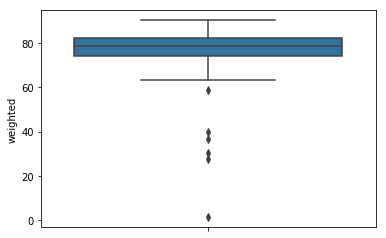

In [34]:
sns.boxplot(y=crr_by_hood['weighted'])

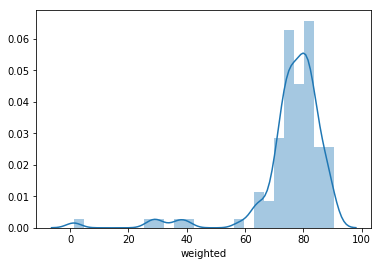

In [35]:
sns.distplot(crr_by_hood['weighted'])

Summary stats and visualizations show that Census Response Rate by neighborhood has a left-skewed distribution, roughly centered around 75% response rate, with some outliers on the low side. The Sylvan-Highlands neighborhood in particular should be investigated further.

In [36]:
# flatten multilevel index dataframe and export census response rate to csv 

for_csv = pd.DataFrame(crr_by_hood.to_records())
for_csv.rename(columns={'weighted':'census_response_rate'}, inplace=True)
for_csv.head()
for_csv.to_csv("Data/neighborhood_census_response_rate.csv")

In [37]:
# merge the census response rates to neighborhood shapes for plotting
pdx_hoods = pdx_hoods.merge(for_csv, on='name', how='inner')

Text(0.5,1,'Census Response Rate by Neighborhood')

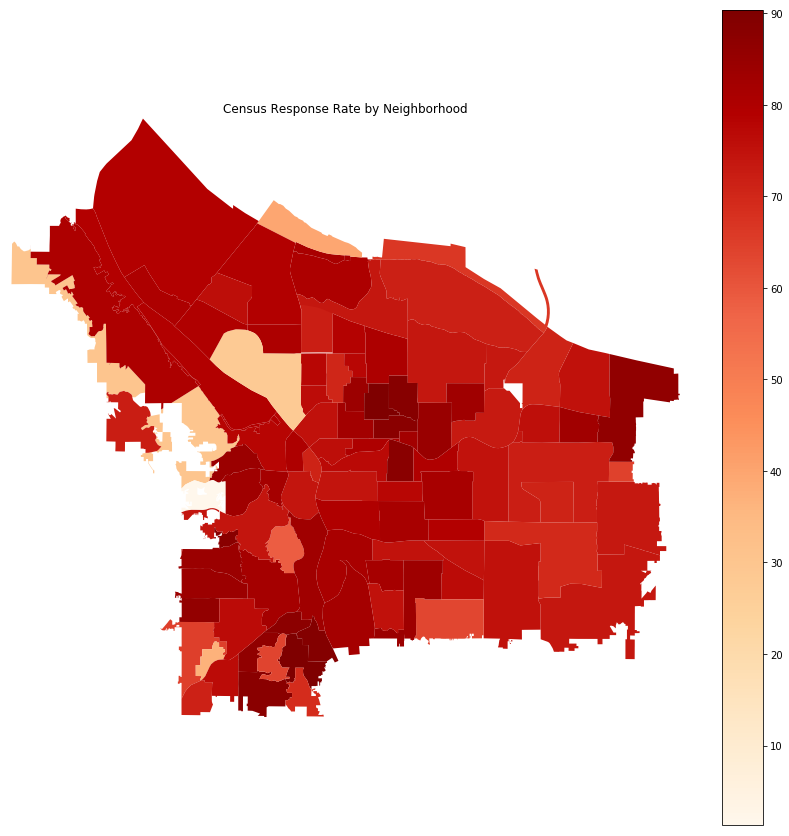

In [38]:
# plot choropleth of population by neighborhood unit

gplt.choropleth(pdx_hoods,
                hue=pdx_hoods['census_response_rate'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(15, 15))

plt.title("Census Response Rate by Neighborhood")

It is interesting how Sylvan Highlands and Overlook are outliers on the low census response rate side. I did not expect these neighborhoods to be so low. The aggregations and method should be validated by investigating individual block group data to see if they are congruent with the data aggregated by neighborhood. 